# Extraction des entités nommées

## ÉTAPE 1: Importer les librairies

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings
)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,preprocess_tokens,create_char_sequences,create_tag_mapping

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","gpu" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  gpu


## ÉTAPE 2: DATA PREPROCESSING

In [2]:
jnlpba_sentences, jnlpbaclasses = load_jnlpba_dataset("./datasets/JNLPBA")
print(jnlpba_sentences[1])

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402 phrases
- 11 Classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]


In [3]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus
Documents chargés: 793
Exemple d'entités dans le premier document: 2
Traité 1000 phrases...
Traité 2000 phrases...
Traité 3000 phrases...
Traité 4000 phrases...
Traité 5000 phrases...
Traité 6000 phrases...
Traité 7000 phrases...
Total de phrases générées (format JNLPBA): 7524

Vérification du format:
Type du premier élément: <class 'tuple'>
Longueur du tuple: 2
Type tokens: <class 'list'> (longueur: 16)
Type labels: <class 'list'> (longueur: 16)
Exemple tokens[:5]: ['Germline', 'mutations', 'in', 'BRCA1', 'are']
Exemple labels[:5]: ['O', 'O', 'O', 'O', 'O']
(['However', ',', 'the', 'function', 'of', 'the', 'BRCA1', 'protein', 'has', 'remained', 'elusive', '.'], ['I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'O', 'O', 'O', 'O', 'O'])


Création de dataset JNLPBA

In [4]:
def create_jnlpba_dataloaders(jnlpba_sentences, batch_size=32, max_seq_len=100, word2vec_path=None):
    """ 
    Crée les Dataloaders avec Word2Vec
    """ 
    # 1. Créer les vocabulaires
    vocab = create_vocab(jnlpba_sentences, min_freq=2)
    char_vocab = create_char_vocab(jnlpba_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(jnlpba_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(jnlpba_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = jnlpba_sentences[:train_size]
    dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
    test_sentences = jnlpba_sentences[train_size + dev_size:]
    
    print(f"JNLPBA - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    word2vec_model = None
    
    if word2vec_path:
        print(f"Tentative de chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    
    if word2vec_model is None:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        
        # Extraire les phrases pour Word2Vec
        tokenized_sentences = [
        [token.lower() for token, label in sentence]
        for sentence in jnlpba_sentences
    ]
            
        
        print(f"Nombre de phrases pour Word2Vec: {len(tokenized_sentences)}")
        print(f"Exemple: {tokenized_sentences[0][:10]}")
        
        # Entraîner Word2Vec
        from gensim.models import Word2Vec
        word2vec_model = Word2Vec(
            sentences=tokenized_sentences,
            vector_size=200,
            window=5,
            min_count=2,
            workers=4,
            sg=1,  # Skip-gram
            epochs=10
        )
        
        print(f"Vocabulaire Word2Vec entraîné: {len(word2vec_model.wv)} mots")
        
        # Sauvegarder le modèle
        if word2vec_path:
            try:
                save_word2vec_model(word2vec_model, word2vec_path)
            except Exception as e:
                print(f"Attention: impossible de sauvegarder le modèle: {e}")
                print("Le modèle sera utilisé en mémoire seulement.")
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE = 32
results_jnlpba = create_jnlpba_dataloaders(jnlpba_sentences,batch_size=BATCH_SIZE,word2vec_path="./word2Vecembeddings/jnlpba_word2vec")

Format vocab: Liste de paires (token, label)
Vocabulaire créé: 12664 mots
Mots uniques: 22678
Mots avec fréquence >= 2: 12661
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 85 caractères
Caractères uniques: 83
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
JNLPBA - Train: 15681, Dev: 3360, Test: 3361
Tentative de chargement du modèle Word2Vec depuis: ./word2Vecembeddings/jnlpba_word2vec
Modèle Word2Vec chargé: ./word2Vecembeddings/jnlpba_word2vec
Mots trouvés dans Word2Vec: 12661
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 15681 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides


In [5]:
train_loader = results_jnlpba['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_jnlpba['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 100])
char_seqs shape: torch.Size([32, 100, 20])
tag_ids shape: torch.Size([32, 100])
lengths: tensor([ 34,  32,  24,  38,  23,  41,  25,  19,  22,  29,  34,  33,  23,  28,
         10,  29, 100,  38,  20,  24,  30,  34,  31,  39,  29,  25,  17,  61,
         28,  20,  27,  26])

Premier exemple du batch:
Word IDs : tensor([  20, 1567,  122,  797,  104, 1831,  759,  113,   20,    1, 1110,  167,
         122,   19,   20,    3,    4,   68, 1710,  785, 1206,  642,   19,   20,
        1054,    4, 1831,  652,  759,  113,   20,    3,    4,   18,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          

In [13]:
def create_ncbi_dataloaders(ncbi_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """
    Crée les DataLoaders pour NCBI avec Word2Vec
    """
    # 1. Créer les vocabulaires
    vocab = create_vocab(ncbi_sentences, min_freq=2)
    char_vocab = create_char_vocab(ncbi_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(ncbi_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(ncbi_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = ncbi_sentences[:train_size]
    dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
    test_sentences = ncbi_sentences[train_size + dev_size:]
    
    print(f"NCBI - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    else:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        # Entraîner sur toutes les données
        word2vec_model = train_word2vec_embeddings(ncbi_sentences)
        
        # Sauvegarder le modèle
        if word2vec_path:
            save_word2vec_model(word2vec_model, word2vec_path)
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }
    
results_ncbi = ncbi_data_loaders = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    word2vec_path="./word2Vecembeddings/ncbi"
)

Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 5925 mots
Mots uniques: 10845
Mots avec fréquence >= 2: 5922
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 10 tags uniques
Tags: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']
NCBI - Train: 5266, Dev: 1128, Test: 1130
Entraînement d'un nouveau modèle Word2Vec...
Nombre de phrases pour Word2Vec: 7524
Première phrase: ['germline', 'mutations', 'in', 'brca1', 'are', 'responsible', 'for', 'most', 'cases', 'of']...
Entraînement du modèle Word2Vec...
Vocabulaire Word2Vec: 5922 mots
Taille des vecteurs: 200
Modèle Word2Vec sauvegardé: ./word2Vecembeddings/ncbi.model
Mots trouvés dans Word2Vec: 5922
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 5266 phrases valides
Dataset créé: 1128 phrases valides
Dat

In [14]:
train_loader = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_ncbi['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_ncbi['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([ 8, 28, 26, 15, 19,  3, 31, 21, 23, 20, 18, 40, 38, 35, 34, 51, 49, 31,
        16, 18, 12, 13, 23,  5,  1, 18, 33,  1, 30,  1, 38, 30])

Premier exemple du batch:
Word IDs : tensor([  21, 3203, 4208, 3209, 3210,  139,    1,   18,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

Model architecture

In [18]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, criterion, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)

        optimizer.zero_grad()
        # Passer les tags → forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list

            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


JNLPBA Dataset

In [23]:
def run_complete_pipeline_with_scheduler(
    dataset_name: str,
    loaders: dict,
    embedding_url: str = None,
    epochs: int = 40,
    patience: int = 4,
    checkpoints_dir="./checkpoints"
):
    """
    Pipeline d'entraînement avec scheduler
    """

    # =========================
    # 1. Récupération des objets existants
    # =========================
   

    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']

    print(f"Vocab size: {len(vocab)}")
    print(f"Char vocab size: {len(char_vocab)}")
    print(f"Number of tags: {len(tag_to_idx)}")

    # =========================
    # 2. Embeddings
    # =========================
    print("\nStep 2: Loading embeddings...")

    if embedding_url:
    # Charger depuis une URL externe
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        # Utiliser les embeddings déjà chargés dans le loader
        pretrained_embeddings = loaders['pretrained_embeddings']
        print(f"Using pretrained embeddings from loader ({pretrained_embeddings.shape[0]} words, {pretrained_embeddings.shape[1]} dim)")
    else:
        # Pas d'embeddings pré-entraînés
        pretrained_embeddings = None
        print("Random word embeddings will be used.")

    # =========================
    # 3. Paramètres selon l'article
    # =========================
    print("\nStep 3: Creating model...")

    if dataset_name == 'JNLPBA':
        cnn_filters = [32, 32, 32]
        cnn_kernels = [3, 5, 7]
        lstm_hidden = 256
    else:  # NCBI-Disease
        cnn_filters = [32, 32, 32]
        cnn_kernels = [2, 3, 4]
        lstm_hidden = 128
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # =========================
    # 4. Optimisation avec scheduler
    # =========================
    print("\nStep 4: Training setup with scheduler...")

    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    
    # Scheduler: ReduceLROnPlateau (réduit le LR quand le plateau est atteint)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',        # On maximise le F1-score
        factor=0.5,        # Réduction de 50%
        patience=2,        # Attendre 2 epochs sans amélioration
        threshold=0.0001,  # Seuil d'amélioration minimum
        min_lr=1e-6        # Learning rate minimum
    )

    # =========================
    # 5. Entraînement + Early stopping + Scheduler
    # =========================
    print("\nStep 5: Training with scheduler...")

    best_f1 = 0.0
    patience_counter = 0
    
    
    # Pour suivre l'historique
    history = {
        'train_loss': [],
        'dev_loss': [],
        'dev_f1': [],
        'lr': []
    }

    for epoch in range(epochs):
        # Entraînement
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Évaluation
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, criterion, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)
        
        # Mettre à jour le scheduler avec le F1-score
        scheduler.step(f1)
        
        # Sauvegarder l'historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_f1': best_f1,
            }, f"{checkpoints_dir}/best_model_{dataset_name}_full.pt")
            print(f"Meilleur modèle sauvegardé (F1: {f1:.4f})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered après {epoch+1} epochs.")
            break

    # =========================
    # 6. Test final
    # =========================
    print("\nStep 6: Final evaluation on test set...")

    # Charger le meilleur modèle
    checkpoint = torch.load(f"{checkpoints_dir}/best_model_{dataset_name}_full.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_loss, test_preds, test_targets = evaluate(
        model,
        test_loader,
        criterion,
        device,
        idx_to_tag
    )

    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)
    
    # Afficher l'historique des learning rates
    print("\nHistorique des learning rates:")
    for i, lr in enumerate(history['lr']):
        if i == 0 or lr != history['lr'][i-1]:
            print(f"  Epoch {i+1}: LR = {lr:.6f}")

    return model, history

In [24]:
model_jnlpba, history_jnlpba = run_complete_pipeline_with_scheduler(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    embedding_url=None,
    epochs=40,
    patience=4,
    checkpoints_dir = "./checkpoints/JNLPBA"
)

Vocab size: 12664
Char vocab size: 85
Number of tags: 12

Step 2: Loading embeddings...
Using pretrained embeddings from loader (12664 words, 200 dim)

Step 3: Creating model...
Model parameters: 3,071,816

Step 4: Training setup with scheduler...

Step 5: Training with scheduler...


Training:   0%|          | 0/491 [00:00<?, ?it/s]

Training: 100%|██████████| 491/491 [01:10<00:00,  7.00it/s]


Epoch 01/40 | Train loss: 758.1662 | Dev loss: 493.8592 | P: 0.0617 R: 0.0751 F1: 0.0635 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.0635)


Training: 100%|██████████| 491/491 [02:01<00:00,  4.04it/s]


Epoch 02/40 | Train loss: 414.2928 | Dev loss: 389.7217 | P: 0.0698 R: 0.1276 F1: 0.0902 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.0902)


Training: 100%|██████████| 491/491 [01:27<00:00,  5.59it/s]


Epoch 03/40 | Train loss: 331.8600 | Dev loss: 327.7517 | P: 0.0687 R: 0.1473 F1: 0.0932 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.0932)


Training: 100%|██████████| 491/491 [01:10<00:00,  6.98it/s]


Epoch 04/40 | Train loss: 281.5495 | Dev loss: 293.5289 | P: 0.0689 R: 0.1497 F1: 0.0936 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.0936)


Training: 100%|██████████| 491/491 [01:12<00:00,  6.81it/s]


Epoch 05/40 | Train loss: 249.5213 | Dev loss: 272.8539 | P: 0.1066 R: 0.1519 F1: 0.0963 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.0963)


Training: 100%|██████████| 491/491 [01:42<00:00,  4.80it/s]


Epoch 06/40 | Train loss: 227.5346 | Dev loss: 258.2019 | P: 0.0925 R: 0.1553 F1: 0.1016 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.1016)


Training: 100%|██████████| 491/491 [02:18<00:00,  3.54it/s]


Epoch 07/40 | Train loss: 212.1706 | Dev loss: 248.7986 | P: 0.1115 R: 0.1554 F1: 0.1105 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.1105)


Training: 100%|██████████| 491/491 [01:27<00:00,  5.61it/s]


Epoch 08/40 | Train loss: 201.5871 | Dev loss: 245.3233 | P: 0.1126 R: 0.1571 F1: 0.1200 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.1200)


Training: 100%|██████████| 491/491 [01:11<00:00,  6.90it/s]


Epoch 09/40 | Train loss: 190.3411 | Dev loss: 236.5484 | P: 0.2341 R: 0.1654 F1: 0.1365 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.1365)


Training: 100%|██████████| 491/491 [01:14<00:00,  6.63it/s]


Epoch 10/40 | Train loss: 181.0417 | Dev loss: 233.6770 | P: 0.2835 R: 0.1900 F1: 0.1791 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.1791)


Training: 100%|██████████| 491/491 [01:19<00:00,  6.16it/s]


Epoch 11/40 | Train loss: 172.1640 | Dev loss: 226.2507 | P: 0.2363 R: 0.2091 F1: 0.1901 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.1901)


Training: 100%|██████████| 491/491 [01:29<00:00,  5.48it/s]


Epoch 12/40 | Train loss: 166.2644 | Dev loss: 224.0411 | P: 0.2264 R: 0.2144 F1: 0.1873 | LR: 0.001000


Training: 100%|██████████| 491/491 [02:27<00:00,  3.33it/s]


Epoch 13/40 | Train loss: 159.3368 | Dev loss: 224.7499 | P: 0.3068 R: 0.2699 F1: 0.2558 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.2558)


Training: 100%|██████████| 491/491 [01:31<00:00,  5.37it/s]


Epoch 14/40 | Train loss: 151.9851 | Dev loss: 247.4847 | P: 0.3117 R: 0.2405 F1: 0.2494 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:28<00:00,  5.56it/s]


Epoch 15/40 | Train loss: 145.9889 | Dev loss: 223.5410 | P: 0.3479 R: 0.3124 F1: 0.3083 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.3083)


Training: 100%|██████████| 491/491 [01:29<00:00,  5.47it/s]


Epoch 16/40 | Train loss: 139.9405 | Dev loss: 230.7883 | P: 0.3322 R: 0.3217 F1: 0.3027 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:27<00:00,  5.59it/s]


Epoch 17/40 | Train loss: 132.9454 | Dev loss: 215.3514 | P: 0.3641 R: 0.3423 F1: 0.3336 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.3336)


Training: 100%|██████████| 491/491 [02:18<00:00,  3.54it/s]


Epoch 18/40 | Train loss: 124.7216 | Dev loss: 211.7839 | P: 0.3993 R: 0.3904 F1: 0.3686 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.3686)


Training: 100%|██████████| 491/491 [01:30<00:00,  5.42it/s]


Epoch 19/40 | Train loss: 115.5918 | Dev loss: 199.6772 | P: 0.3908 R: 0.4137 F1: 0.3878 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.3878)


Training: 100%|██████████| 491/491 [04:11<00:00,  1.95it/s]


Epoch 20/40 | Train loss: 106.0573 | Dev loss: 187.0468 | P: 0.4080 R: 0.4380 F1: 0.4122 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.4122)


Training: 100%|██████████| 491/491 [06:04<00:00,  1.35it/s]


Epoch 21/40 | Train loss: 95.8462 | Dev loss: 172.7276 | P: 0.6258 R: 0.5433 F1: 0.5587 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.5587)


Training: 100%|██████████| 491/491 [01:58<00:00,  4.14it/s]


Epoch 22/40 | Train loss: 87.2480 | Dev loss: 165.2269 | P: 0.6566 R: 0.5865 F1: 0.5943 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.5943)


Training: 100%|██████████| 491/491 [03:32<00:00,  2.31it/s]


Epoch 23/40 | Train loss: 80.5716 | Dev loss: 161.5988 | P: 0.6624 R: 0.6215 F1: 0.6343 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6343)


Training: 100%|██████████| 491/491 [01:38<00:00,  5.00it/s]


Epoch 24/40 | Train loss: 74.7280 | Dev loss: 170.8624 | P: 0.6979 R: 0.6092 F1: 0.6417 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6417)


Training: 100%|██████████| 491/491 [01:39<00:00,  4.93it/s]


Epoch 25/40 | Train loss: 70.2677 | Dev loss: 159.7643 | P: 0.6964 R: 0.6345 F1: 0.6545 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6545)


Training: 100%|██████████| 491/491 [01:20<00:00,  6.10it/s]


Epoch 26/40 | Train loss: 66.0873 | Dev loss: 153.3905 | P: 0.6928 R: 0.6518 F1: 0.6681 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6681)


Training: 100%|██████████| 491/491 [01:19<00:00,  6.16it/s]


Epoch 27/40 | Train loss: 62.2829 | Dev loss: 148.3986 | P: 0.7053 R: 0.6473 F1: 0.6678 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:20<00:00,  6.08it/s]


Epoch 28/40 | Train loss: 59.5079 | Dev loss: 148.5928 | P: 0.7040 R: 0.6541 F1: 0.6716 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6716)


Training: 100%|██████████| 491/491 [01:20<00:00,  6.11it/s]


Epoch 29/40 | Train loss: 56.7665 | Dev loss: 148.6777 | P: 0.7035 R: 0.6688 F1: 0.6821 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6821)


Training: 100%|██████████| 491/491 [01:20<00:00,  6.08it/s]


Epoch 30/40 | Train loss: 54.2360 | Dev loss: 143.0682 | P: 0.7114 R: 0.6694 F1: 0.6859 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6859)


Training: 100%|██████████| 491/491 [01:23<00:00,  5.86it/s]


Epoch 31/40 | Train loss: 52.6502 | Dev loss: 153.5150 | P: 0.7252 R: 0.6607 F1: 0.6886 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6886)


Training: 100%|██████████| 491/491 [01:19<00:00,  6.20it/s]


Epoch 32/40 | Train loss: 51.2286 | Dev loss: 152.3945 | P: 0.6978 R: 0.6967 F1: 0.6957 | LR: 0.001000
Meilleur modèle sauvegardé (F1: 0.6957)


Training: 100%|██████████| 491/491 [02:18<00:00,  3.54it/s]


Epoch 33/40 | Train loss: 49.5103 | Dev loss: 147.2125 | P: 0.6919 R: 0.6858 F1: 0.6865 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:13<00:00,  6.71it/s]


Epoch 34/40 | Train loss: 47.5659 | Dev loss: 151.4097 | P: 0.6941 R: 0.6919 F1: 0.6909 | LR: 0.001000


Training: 100%|██████████| 491/491 [02:04<00:00,  3.95it/s]


Epoch 35/40 | Train loss: 46.6964 | Dev loss: 151.6263 | P: 0.7029 R: 0.6895 F1: 0.6939 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:45<00:00,  4.64it/s]


Epoch 36/40 | Train loss: 42.1517 | Dev loss: 162.5667 | P: 0.6921 R: 0.6840 F1: 0.6860 | LR: 0.000500

Early stopping triggered après 36 epochs.

Step 6: Final evaluation on test set...

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 180.7142
Precision: 0.6081
Recall: 0.6653
F1-score: 0.6284

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 35: LR = 0.000500


In [ ]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(jnlpba_data, './vocab/jnlpba')

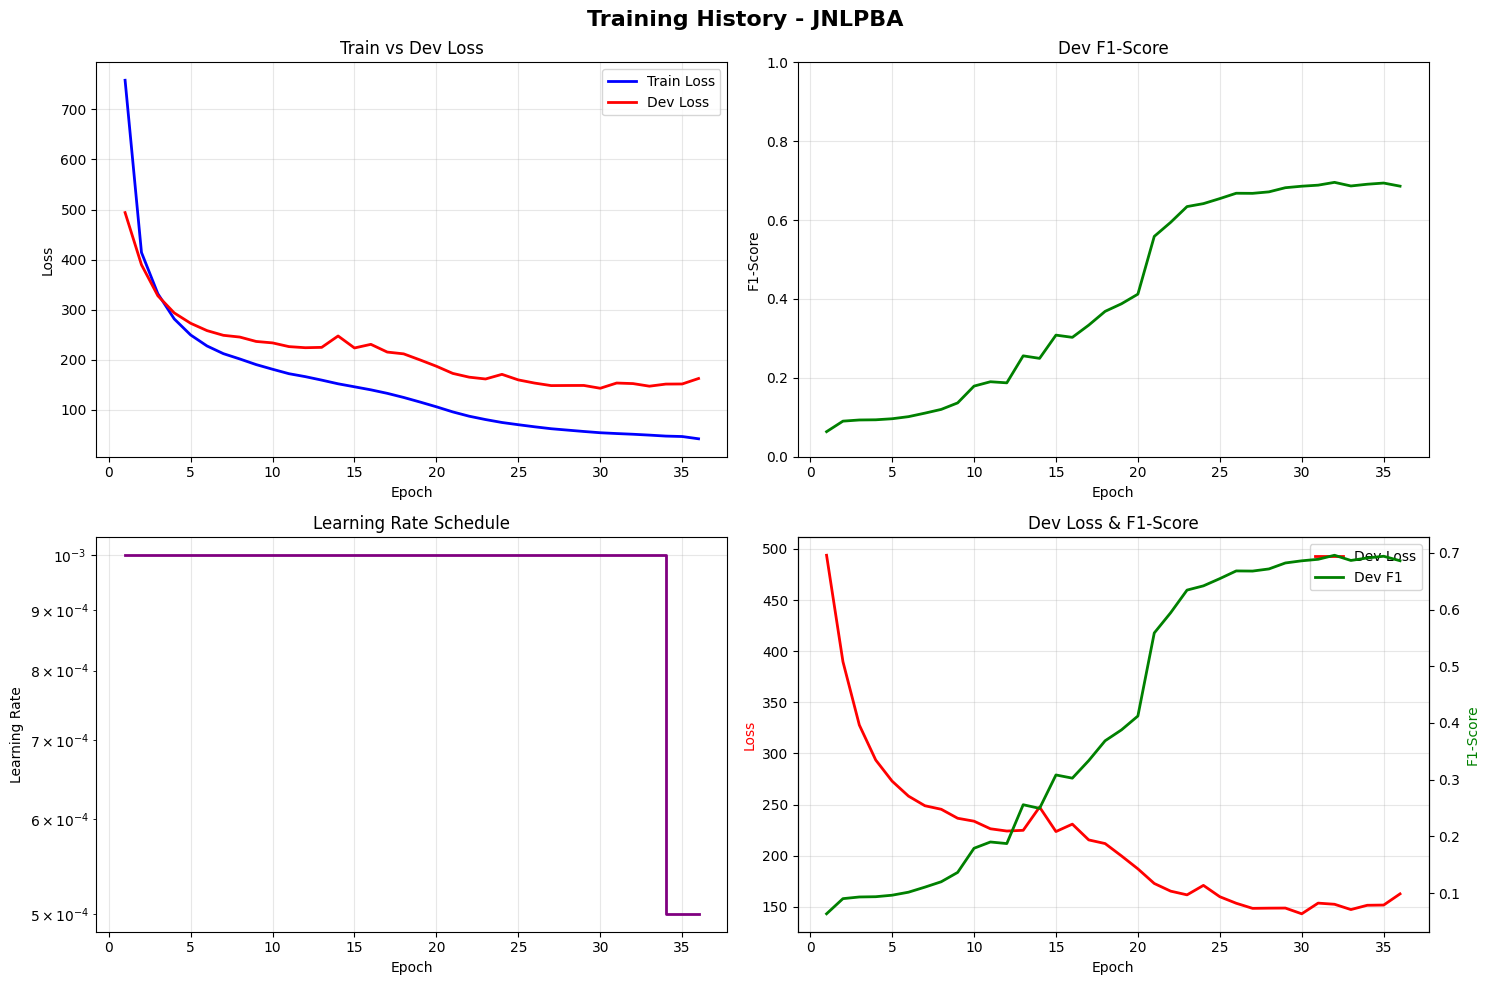

STATISTIQUES FINALES - JNLPBA
Meilleur F1-score (dev): 0.6957
Final train loss: 42.1517
Final dev loss: 162.5667
Final learning rate: 0.000500


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Train vs Dev Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], 'r-', label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: F1-Score
    axes[0, 1].plot(epochs, history['dev_f1'], 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].set_title('Dev F1-Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    axes[1, 0].step(epochs, history['lr'], 'purple', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Combined (Loss + F1)
    ax2 = axes[1, 1].twinx()
    line1, = axes[1, 1].plot(epochs, history['dev_loss'], 'r-', label='Dev Loss', linewidth=2)
    line2, = ax2.plot(epochs, history['dev_f1'], 'g-', label='Dev F1', linewidth=2)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss', color='r')
    ax2.set_ylabel('F1-Score', color='g')
    axes[1, 1].set_title('Dev Loss & F1-Score')
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    axes[1, 1].legend(lines, labels, loc='upper right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print(f"STATISTIQUES FINALES - {dataset_name}")

    print(f"Meilleur F1-score (dev): {max(history['dev_f1']):.4f}")
    print(f"Final train loss: {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss: {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate: {history['lr'][-1]:.6f}")
    
plot_training_history(history_jnlpba, dataset_name="JNLPBA")

In [ ]:
def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10)):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Filtrer les tags 'O' pour se concentrer sur les entités
    entity_predictions = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O':  # On garde seulement les entités (pas le background)
            entity_predictions.append(pred)
            entity_targets.append(target)
    
    # Obtenir les classes uniques (sauf 'O')
    unique_tags = sorted(set(entity_targets + entity_predictions))
    
    # Créer la matrice de confusion
    cm = confusion_matrix(entity_targets, entity_predictions, labels=unique_tags)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title_suffix = '(Normalisée)'
    else:
        fmt = 'd'
        title_suffix = '(Absolue)'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=unique_tags, yticklabels=unique_tags)
    plt.title(f'Matrice de Confusion - {dataset_name} {title_suffix}', fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies labels')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Afficher le rapport de classification détaillé
    print(f"\n{'='*60}")
    print(f"RAPPORT DE CLASSIFICATION DÉTAILLÉ - {dataset_name}")
    print('='*60)
    
    report = classification_report(entity_targets, entity_predictions, 
                                   labels=unique_tags, zero_division=0)
    print(report)
    
    # Calculer les statistiques par classe
    print(f"\n{'='*60}")
    print(f"STATISTIQUES PAR CLASSE - {dataset_name}")
    print('='*60)
    
    for i, tag in enumerate(unique_tags):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{tag:15s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, "
              f"Support={int(cm[i, :].sum())}")

In [ ]:
def main(data_dir = "./dataset/JNLPBA",dataset_name="JNLPBA"):
    """
    Example usage for both datasets
    """
    # For JNLPBA dataset
    print("=" * 60)
    print(f"Training on {data_dir} dataset")
    print("=" * 60)
    
    
    # Run pipeline for JNLPBA
    model_jnlpba, vocab_jnlpba, char_vocab_jnlpba, tag_to_idx_jnlpba = run_complete_pipeline(
        dataset_name=dataset_name,
        data_dir=data_dir,
        embedding_url=None,  
        epochs=40,
        patience=4
    )
   

if __name__ == "__main__":
    main(data_dir = "./dataset/JNLPBA")
    main(data_dir = "./dataset/NCBI-Corpus")